In [141]:
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import numpy as np
import scipy.stats as sst
import scipy.signal as snl
from statsmodels.formula.api import ols, quantreg
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image, display

from nems_lbhb.baphy_io import  get_mean_spike_waveform

from src.data.load import load
from src.root_path import config_path
from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts
from src.data.cell_type import get_phototags, get_waveform_metrics
from src.root_path import config_path


config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [2]:
# quick and dirty, get the celltype dataframe, merge to main DF and run categorical linear regressions
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '220816_CPN_celltype_DF'
type_DF = jl.load(type_DF_file)
type_DF = type_DF.loc[:, ['id', 'spike_type', 'phototag']]
type_DF.dropna(subset=['spike_type', 'phototag'], how='all')
type_DF.head()

,id,spike_type,phototag
0,TNC016a-43-3,broad,s
1,TNC029a-43-2,narrow,s
2,CRD002a-44-1,broad,NaN
3,CRD019b-27-5,broad,NaN
4,TNC013a-046-2,broad,n


In [3]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
DF.head()

(91816, 8)


,id,context_pair,probe,value,metric,site,region,trans_pair
0,CRD005b-06-1,00_01,1,125.093269,integral,CRD005b,A1,same_silence
1,CRD005b-20-1,00_01,1,71.514473,integral,CRD005b,A1,same_silence
2,CRD005b-21-1,00_01,1,220.570374,integral,CRD005b,A1,same_silence
3,CRD005b-28-1,00_01,1,179.131516,integral,CRD005b,A1,same_silence
4,CRD005b-40-2,00_01,1,257.713257,integral,CRD005b,A1,same_silence


In [4]:
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

toregress = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
toregress['norm_val'] = toregress['value']/toregress['grand_mean']
toregress = pd.merge(toregress, type_DF, on='id', validate="m:1")

# the simplest approach is to manually map the 4 categories into onehots
# onehot order: diff same silence
mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}
toregress['onehot'] = toregress['trans_pair'].replace(mapper)

onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
toregress = pd.concat([toregress, onehotdf], axis=1)

toregress.drop(columns='onehot', inplace=True)
del(onehotdf)
print(toregress.shape)
toregress.head()

(60144, 15)


,id,context_pair,probe,value,metric,site,region,trans_pair,grand_mean,norm_val,spike_type,phototag,diff,same,silence
0,CRD005b-06-1,00_01,1,125.093269,integral,CRD005b,A1,same_silence,236.439667,0.529071,narrow,NaN,0,1,1
1,CRD005b-06-1,00_02,2,117.734840,integral,CRD005b,A1,same_silence,236.439667,0.497949,narrow,NaN,0,1,1
2,CRD005b-06-1,01_04,2,125.093269,integral,CRD005b,A1,diff_diff,236.439667,0.529071,narrow,NaN,1,0,0
3,CRD005b-06-1,00_03,3,176.602264,integral,CRD005b,A1,same_silence,236.439667,0.746923,narrow,NaN,0,1,1
4,CRD005b-06-1,00_01,1,200.000000,last_bin,CRD005b,A1,same_silence,249.251770,0.802402,narrow,NaN,0,1,1


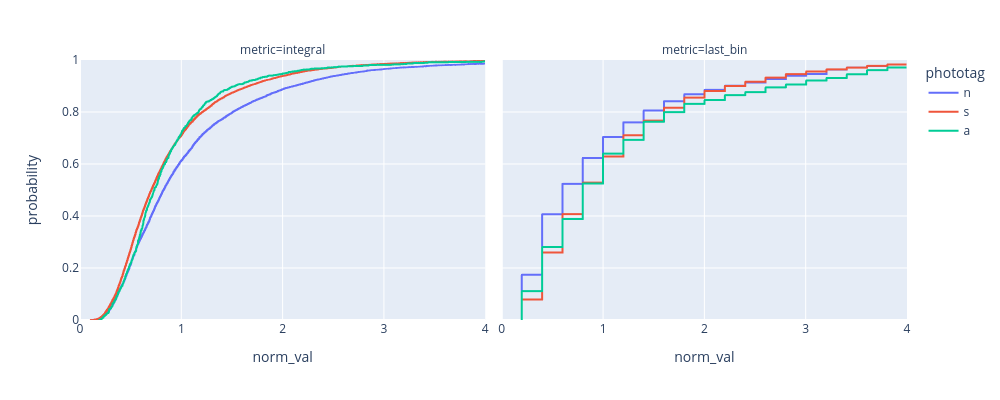

In [5]:
toplot = toregress.dropna(subset='phototag')

fig = px.ecdf(toplot, x="norm_val",  color='phototag', facet_col='metric')
fig.update_xaxes(range=[0,4])
fig.update_yaxes(range=[0,1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [6]:
d = toregress.query("metric == 'integral'").dropna(subset='phototag')
mod = ols("norm_val ~ C(phototag)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     222.2
Date:                Thu, 01 Sep 2022   Prob (F-statistic):           1.95e-96
Time:                        14:55:28   Log-Likelihood:                -31084.
No. Observations:               26339   AIC:                         6.217e+04
Df Residuals:                   26336   BIC:                         6.220e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8923      0.023  

In [7]:
d = toregress.query("metric == 'last_bin'").dropna(subset='phototag')
mod = ols("norm_val ~ C(phototag)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     78.55
Date:                Thu, 01 Sep 2022   Prob (F-statistic):           9.69e-35
Time:                        14:55:28   Log-Likelihood:                -33905.
No. Observations:               26339   AIC:                         6.782e+04
Df Residuals:                   26336   BIC:                         6.784e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1735      0.026  

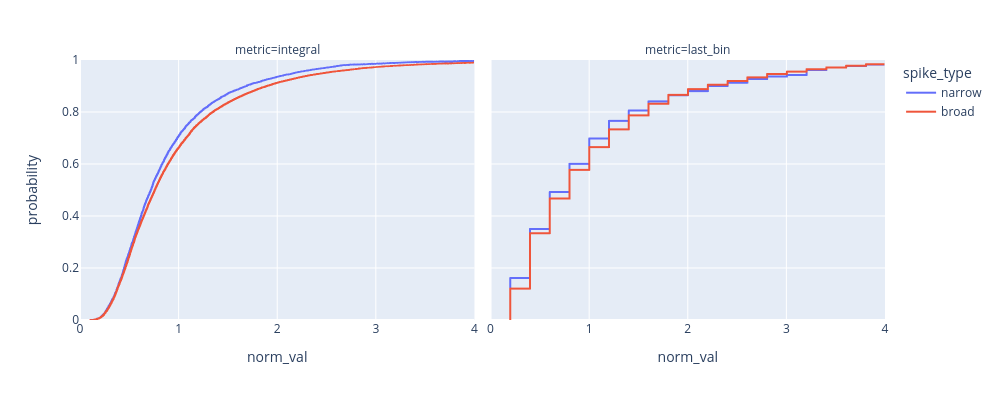

In [8]:
toplot = toregress.dropna(subset='spike_type')

fig = px.ecdf(toplot, x="norm_val",  color='spike_type', facet_col='metric')
fig.update_xaxes(range=[0,4])
fig.update_yaxes(range=[0,1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [9]:
d = toregress.query("metric == 'last_bin'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(spike_type)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.385
Date:                Thu, 01 Sep 2022   Prob (F-statistic):             0.0203
Time:                        14:55:33   Log-Likelihood:                -37492.
No. Observations:               29379   AIC:                         7.499e+04
Df Residuals:                   29377   BIC:                         7.500e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [10]:
d = toregress.query("metric == 'integral'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(spike_type)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     74.23
Date:                Thu, 01 Sep 2022   Prob (F-statistic):           7.31e-18
Time:                        14:55:33   Log-Likelihood:                -34679.
No. Observations:               29379   AIC:                         6.936e+04
Df Residuals:                   29377   BIC:                         6.938e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# double classification
now look only at those neurons that have both a phototag and a waveform
we have then a (broad, narrow) by (n, a, s) cartesian product. Some of these combinations are of note:

Narrow * activated -> Unequivocaly inhibitory interneuronse
Broad * suppressed -> most likely pyramidal neurons

Narrow * suppressed -> putative inhibitory interneurons ?
Broad * activated -> this should *NOT EXIST*. Inhibitory interneuron have narrow waveforms

Narrow * non-responsive -> putative inhibitory
Broad * non-responsive -> putative exitatory <- check this groups


In [11]:
double_df = toregress.dropna(subset=['spike_type', 'phototag'], how='any').copy()
double_df['double_class'] = double_df['spike_type'].astype(str) + '_' + double_df['phototag'].astype(str)
double_df['double_class'] = double_df['double_class'].astype('category')
double_df.reset_index(drop=True, inplace=True)
double_df.head()

,id,context_pair,probe,value,metric,site,region,trans_pair,grand_mean,norm_val,spike_type,phototag,diff,same,silence,double_class
0,TNC016a-56-1,00_02,1,257.902893,integral,TNC016a,A1,diff_silence,236.439667,1.090777,narrow,n,1,0,1,narrow_n
1,TNC016a-56-1,00_03,1,148.489548,integral,TNC016a,A1,diff_silence,236.439667,0.628023,narrow,n,1,0,1,narrow_n
2,TNC016a-56-1,00_07,1,184.960663,integral,TNC016a,A1,diff_silence,236.439667,0.782274,narrow,n,1,0,1,narrow_n
3,TNC016a-56-1,02_04,1,211.011459,integral,TNC016a,A1,diff_diff,236.439667,0.892454,narrow,n,1,0,0,narrow_n
4,TNC016a-56-1,03_04,1,151.094620,integral,TNC016a,A1,diff_diff,236.439667,0.639041,narrow,n,1,0,0,narrow_n


In [12]:
# count of neuronse per category
double_df.groupby(by=['id','double_class']).agg(value = ('value', 'mean')
                                                ).groupby('double_class').agg(count=('value', 'count'))

,count
double_class,
broad_a,14
broad_n,155
broad_s,191
narrow_a,25
narrow_n,28
narrow_s,44


In [13]:
# count of instances per category
double_df.groupby('double_class').agg(count=('value', 'count'))

,count
double_class,
broad_a,522
broad_n,19272
broad_s,20864
narrow_a,1744
narrow_n,4482
narrow_s,4408


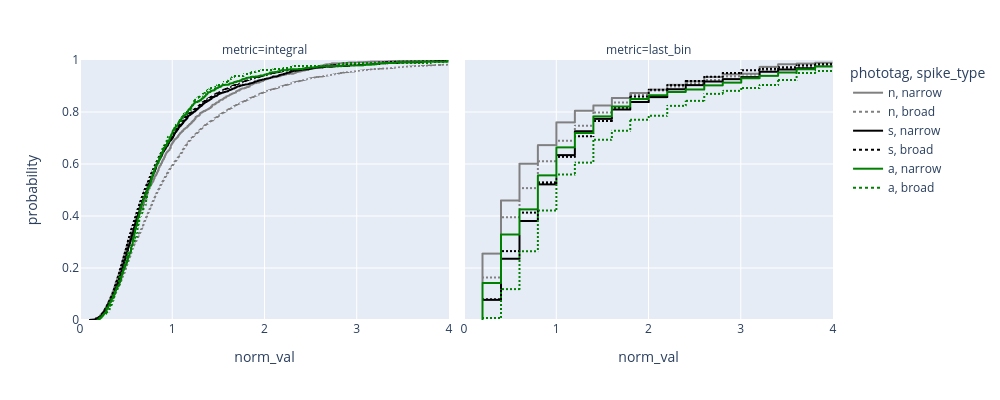

In [14]:
toplot = double_df

fig = px.ecdf(toplot, x="norm_val", color='phototag', line_dash='spike_type', facet_col='metric',
              color_discrete_map={"a": "green",
                                  "s": "black",
                                  "n": "gray"},
              line_dash_map={'narrow': 'solid',
                             'broad': 'dot'}
              )
fig.update_xaxes(range=[0, 4])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [15]:
d = double_df.query("metric == 'integral'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(double_class)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     117.1
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          7.92e-123
Time:                        14:55:37   Log-Likelihood:                -30320.
No. Observations:               25646   AIC:                         6.065e+04
Df Residuals:                   25640   BIC:                         6.070e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# check the clusters
there is really few activated neurons, is everything ok?

In [16]:
def plot_waveforn_cluster(DF):
    DF = DF.dropna(axis=0)
    csw = DF['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
    cptr = DF['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
    ces = DF['es'].values
    wf = DF['waveform_norm'].values
    trough = DF['trough'].values
    labels = DF['spike_type'].values ==  'narrow'

    f, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].scatter(csw[labels == 1], ces[labels == 1], s=10)
    ax[0].scatter(csw[labels == 0], ces[labels == 0], s=10)
    ax[0].set_xlabel('Spike width (ms)')
    ax[0].set_ylabel('Endslope')
    ax[0].set_title(f"Group 1: {sum(labels == 1)}, Group 2: {sum(labels == 0)}")

    ax[1].scatter(csw[labels == 1], cptr[labels == 1], s=10)
    ax[1].scatter(csw[labels == 0], cptr[labels == 0], s=10)
    ax[1].set_xlabel('Spike width (ms)')
    ax[1].set_ylabel('Peak-trough ratio')

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])

        if labels[w] == 0:
            color = 'moccasin'
        else:
            color = 'tab:blue'
        centered.append(wave)
        ax[2].plot(time, wave, color=color, alpha=0.4)

    ax[2].plot(time, np.stack(centered)[labels == 0, :].mean(axis=0), color='darkorange', lw=3, zorder=500)
    ax[2].plot(time, np.stack(centered)[labels == 1, :].mean(axis=0), color='navy', lw=3, zorder=500)

    # categorize as NS / RS -- force Narrow to be label==1
    if csw[labels == 1].mean() < csw[labels == 0].mean():
        ax[2].set_title(f"NS: {sum(labels == 1)}, RS: {sum(labels == 0)}")
    else:
        ax[2].set_title(f"NS: {sum(labels == 0)}, RS: {sum(labels == 1)}")

    f.tight_layout()

    plt.show()
    return ax

In [17]:
goodcells = double_df.id.unique().tolist()

In [18]:
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '220816_CPN_celltype_DF'
wave_DF = jl.load(type_DF_file).query(f"id in {goodcells}")
wave_DF.head()

,id,sw,ptr,fwhm,es,bs,trough,waveform_norm,isolation,spike_type,siteid,phototag
4,TNC013a-046-2,0.752213,0.196419,0.232880,0.195018,0.606800,4913.0,"[0.013928735708875942, 0.01412809465192208, 0....",95.0,broad,TNC013a,n
6,TNC016a-07-3,0.417653,0.227067,0.141040,0.236883,0.689073,4926.0,"[-0.01678449105352505, -0.016771421012665183, ...",95.0,broad,TNC016a,n
8,TNC047a-40-1,0.547487,0.192683,0.266227,0.209595,0.619100,4989.0,"[-3.231270457523805e-06, -4.950339318739172e-0...",95.0,broad,TNC047a,s
14,TNC014a-04-2,0.647253,0.144997,0.306133,0.205514,0.588760,4939.0,"[0.019946019521630567, 0.019975146502824878, 0...",95.0,broad,TNC014a,s
17,TNC014a-52-2,0.285907,0.205385,0.140220,0.223332,0.783100,4960.0,"[0.006890853789854032, 0.006945665437814913, 0...",95.0,broad,TNC014a,n


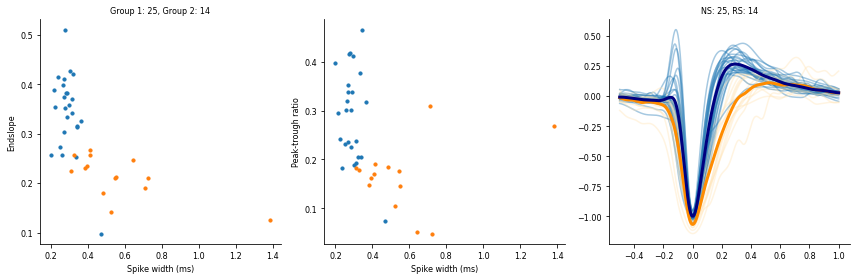

In [19]:
axes = plot_waveforn_cluster(wave_DF.query("phototag == 'a'"))

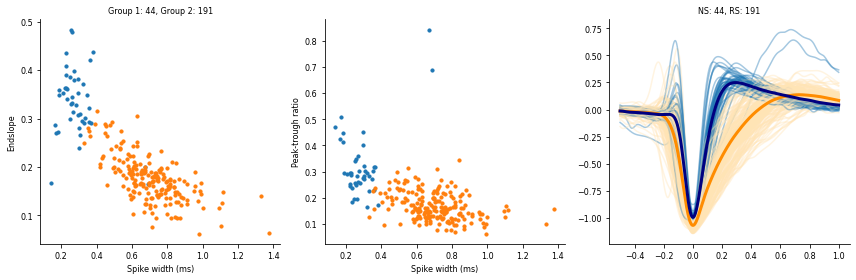

In [20]:
axes = plot_waveforn_cluster(wave_DF.query("phototag == 's'"))

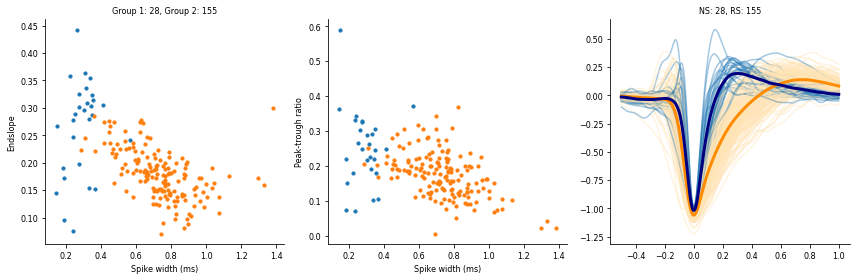

In [21]:
axes = plot_waveforn_cluster(wave_DF.query("phototag == 'n'"))

In [22]:
wave_DF.head()

,id,sw,ptr,fwhm,es,bs,trough,waveform_norm,isolation,spike_type,siteid,phototag
4,TNC013a-046-2,0.752213,0.196419,0.232880,0.195018,0.606800,4913.0,"[0.013928735708875942, 0.01412809465192208, 0....",95.0,broad,TNC013a,n
6,TNC016a-07-3,0.417653,0.227067,0.141040,0.236883,0.689073,4926.0,"[-0.01678449105352505, -0.016771421012665183, ...",95.0,broad,TNC016a,n
8,TNC047a-40-1,0.547487,0.192683,0.266227,0.209595,0.619100,4989.0,"[-3.231270457523805e-06, -4.950339318739172e-0...",95.0,broad,TNC047a,s
14,TNC014a-04-2,0.647253,0.144997,0.306133,0.205514,0.588760,4939.0,"[0.019946019521630567, 0.019975146502824878, 0...",95.0,broad,TNC014a,s
17,TNC014a-52-2,0.285907,0.205385,0.140220,0.223332,0.783100,4960.0,"[0.006890853789854032, 0.006945665437814913, 0...",95.0,broad,TNC014a,n


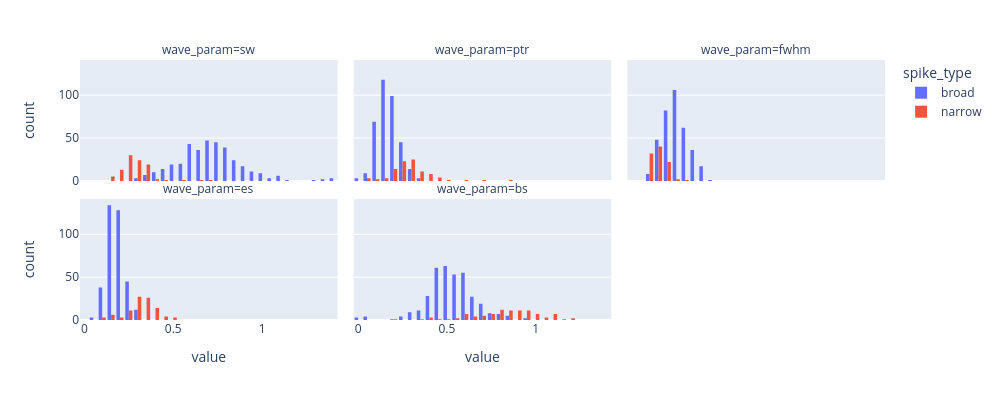

In [23]:
tohist = wave_DF.melt(id_vars=['id', 'phototag', 'spike_type'], value_vars=['sw', 'ptr', 'fwhm', 'es', 'bs'],
                      var_name='wave_param', value_name='value')


fig = px.histogram(tohist, x='value', facet_col='wave_param', color='spike_type', barmode='group', facet_col_wrap=3)

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

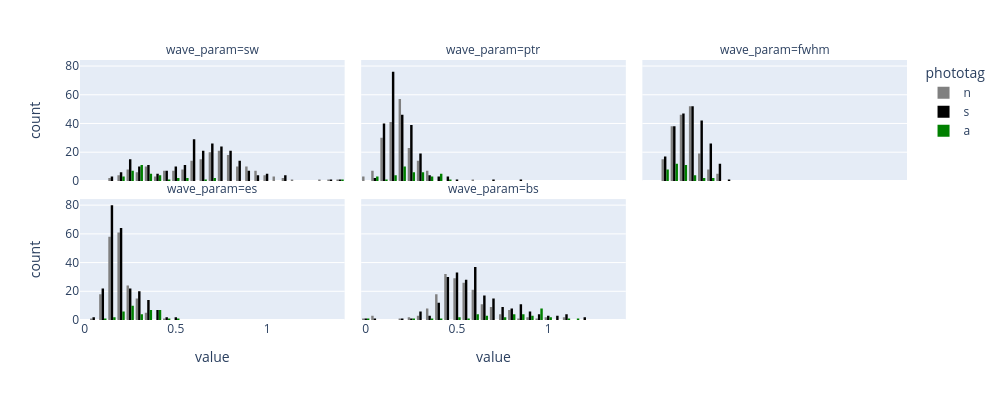

In [24]:
tohist = wave_DF.melt(id_vars=['id', 'phototag', 'spike_type'], value_vars=['sw', 'ptr', 'fwhm', 'es', 'bs'],
                      var_name='wave_param', value_name='value')

fig = px.histogram(tohist, x='value', facet_col='wave_param', color='phototag', barmode='group', facet_col_wrap=3,
                   color_discrete_map={"a": "green",
                                       "s": "black",
                                       "n": "gray"}, )

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

# focus on spike width
The photo tagged units are restricted to narrow waveforms, whereas they are spread across all other categories.
Let just define categories based on spike waveforms

In [25]:
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '220816_CPN_celltype_DF'
# toclust = jl.load(type_DF_file).dropna(subset=['sw', 'ptr', 'fwhm', 'es', 'bs'], how='any')
# toclust = jl.load(type_DF_file)
toclust = jl.load(type_DF_file).dropna(subset='sw')
print(toclust.shape)
toclust['siteid'] = toclust['id'].str.split('-').str[0]

# refresh phototags
pt = get_phototags()
pt.rename(columns={'cellid': 'id'}, inplace=True)
toclust.drop(columns=['phototag'], inplace=True)
toclust = pd.merge(toclust, pt, on=['siteid','id'], validate="1:1", how='left')

# uniffied phototagg, merge suppressed and neutral. names untagged
toclust['phototag2'] = toclust['phototag'].astype(object)
toclust.phototag2.replace({'n':'n+s', 's':'n+s'},inplace=True)
toclust.loc[toclust.phototag2.isnull(),'phototag2'] = 'untagged'
toclust['phototag2'] = toclust['phototag2'].astype('category')



# just activated
toclust['phototag3'] = toclust['phototag'].astype(object)
toclust.phototag3.replace({'a':True, 'n':False, 's':False},inplace=True)
toclust.loc[toclust.phototag3.isnull(),'phototag3'] = False
toclust['phototag3'] = toclust['phototag3'].astype(bool)


print(toclust.shape)
print(toclust.groupby(['phototag2']).agg(cell_count=('id', 'count')))
print(toclust.groupby(['phototag3']).agg(cell_count=('id', 'count')))

(1630, 12)
(1630, 14)
           cell_count
phototag2            
a                  51
n+s               885
untagged          694
           cell_count
phototag3            
False            1579
True               51


### find clusters
by simple historgram threshold. **this is working pretty well**

waveform threshold 0.42424242424242425


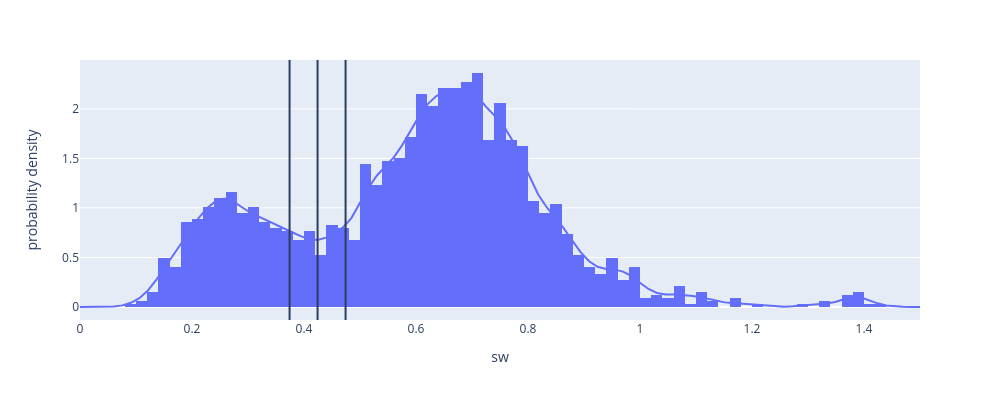

In [89]:
# define kernel density estimate, the bandwidth is defined empirically
kernel = sst.gaussian_kde(toclust.loc[~toclust.sw.isnull(), 'sw'], 0.1)
x = np.linspace(0, 1.5, 100)
hist = kernel(x)

# find valley in bimodal distribution
min_idx = snl.argrelmin(hist)[0]
# print(x[min_idx])
hist_threshold = x[min_idx[0]]
print(f'waveform threshold {hist_threshold}')
margin = 0.05 # plus or minus in ms

# Classifies base on valley plus an unclasified zone of 0.1ms
named_labels = np.empty(len(toclust['sw']), dtype=object)
named_labels[toclust['sw'] < (hist_threshold - margin)] = 'narrow'
named_labels[np.logical_and((hist_threshold - margin) <= toclust['sw'],
                            (toclust['sw'] < (hist_threshold + margin)))] = 'unclass'
named_labels[(hist_threshold + margin) <= toclust['sw']] = 'broad'

toclust['sw_kde'] = named_labels

# plot KDE on top of histogram
KDE_line = px.line(x=x, y=hist)
fig = px.histogram(toclust, x='sw', nbins=100, histnorm='probability density')
fig.add_traces(KDE_line['data'])
fig.add_vline(x=hist_threshold)
fig.add_vline(x=hist_threshold-margin)
fig.add_vline(x=hist_threshold+margin)
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

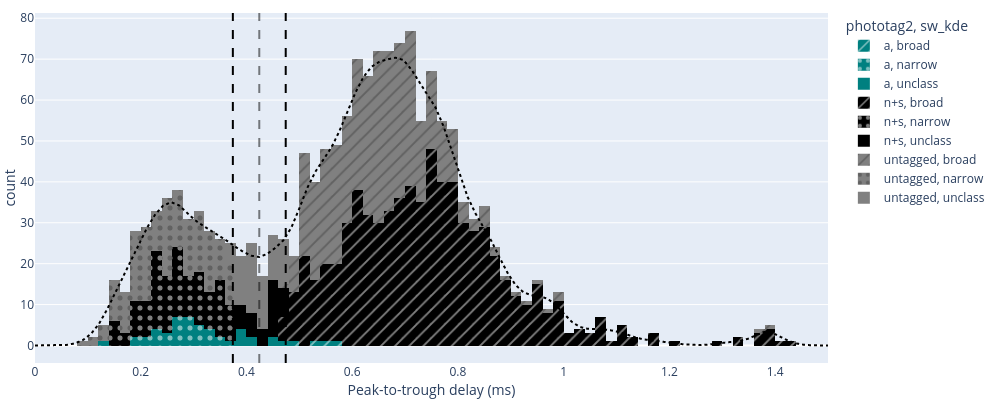

In [90]:
fig = px.histogram(toclust.dropna(subset=['phototag2']), nbins=100,
                   x='sw', color='phototag2',
                   pattern_shape='sw_kde',
                   pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
                   barmode='stack',
                   color_discrete_map={'a': "teal", 'n+s': "black", 'untagged':'gray'},
                   category_orders={'phototag2': ['a', 'n+s', 'untagged']},
                   )

# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toclust['sw'], 0.1)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 32
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='black', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash'),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash'))
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash'))

fig.update_layout(margin=dict(t=10,b=10,l=10,r=10),
                  yaxis=dict(title_standoff=0),
                  xaxis=dict(title=dict(standoff=0, text='Peak-to-trough delay (ms)')),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

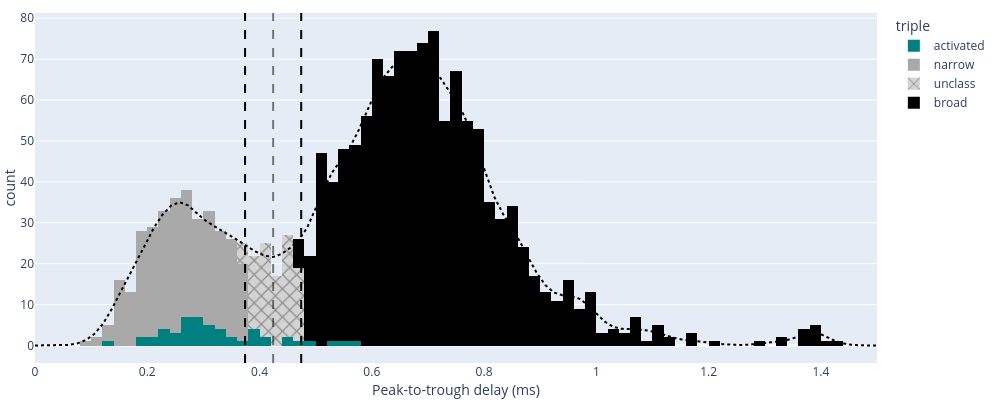

In [168]:
fig = px.histogram(toclust.dropna(subset=['triple']), nbins=100,
                   x='sw', color='triple',
                   pattern_shape='triple',
                   pattern_shape_map={'activated': '', 'narrow': "", "unclass": "x", "broad": ""},
                   barmode='stack',
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', "unclass": 'lightgray', "broad": 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'unclass', 'broad']},
                   )


# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toclust['sw'], 0.1)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 32
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='black', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash'),opacity=0.5)
fig.add_vline(x=hist_threshold-margin, line=dict(color='black', dash='dash'))
fig.add_vline(x=hist_threshold+margin, line=dict(color='black', dash='dash'))

fig.update_layout(margin=dict(t=10,b=10,l=10,r=10),
                  yaxis=dict(title_standoff=0),
                  xaxis=dict(title=dict(standoff=0, text='Peak-to-trough delay (ms)')),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [74]:
toclust.triple.unique()

['broad', 'narrow', 'unclass', 'activated']
Categories (4, object): ['activated', 'broad', 'narrow', 'unclass']

### double classification
This should not change much, the idea is that we merge putative narrow wave with photoactivated and we call it
putative inhibitory interneurons. on the oter hand we take broad spikes that are not photo activated and we
classify them as putative exitatory neurons. In other words the narrow wave cluster is gaining some exited neurons,
and the wide cluster is loosing some.

In [29]:
putative = np.empty(toclust.shape[0], dtype=object)
inhibitory = np.logical_or(toclust.phototag3, toclust.sw_kde == 'narrow')

pyramidal = np.logical_and(~toclust.phototag3,
                           toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3,
                         toclust.sw_kde == 'unclass')


putative[inhibitory] = 'inhibitory'
putative[pyramidal] = 'pyramidal'
putative[unclass] = 'unclass'

toclust['putative'] = pd.Series(putative, dtype='category')

### Triple classification
Focus on narrow vs broad, pulling out the third clasiffication: activated, as a confirmation of narrrow

In [30]:
triple = np.empty(toclust.shape[0], dtype=object)
activated = toclust.phototag == 'a'
narrow = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'narrow')
broad = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'unclass')

triple[toclust.phototag3] = 'activated'
triple[narrow] = 'narrow'
triple[broad] = 'broad'
triple[unclass] = 'unclass'

toclust['triple'] = pd.Series(triple, dtype='category')

# effects by time chunks
lets focus on significant contextual modulation amplitude for chunks A and B, keeping instances that are significant
at any point in time

In [34]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
# metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D']
metrics = ['integral', 'integral_nosig_A', 'integral_nosig_B', 'integral_nosig_C', 'integral_nosig_D']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' "
                                    )

# now filter the chunks based on the significance of the full probe
DF = pd.merge(DF.query("metric == 'integral' and value > 0").loc[:, ['id', 'context_pair', 'probe']],
              DF.query(f"metric in {[m for m in metrics if m != 'integral']}"),
              on=['id', 'context_pair', 'probe'], validate="1:m" )


DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

DF['chunk'] = DF.metric.str.split('_').str[-1]
DF['metric'] = DF.metric.str.split('_').str[0] + '_non_sig'

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

toregress = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
toregress['norm_val'] = toregress['value']/toregress['grand_mean']
toregress = pd.merge(toregress,
                     toclust.loc[:,['id', 'phototag', 'phototag2', 'sw_kde']],
                     on='id', validate="m:1").reset_index(drop=True)
print(toregress.shape)
toregress.head()

(183632, 9)
(117516, 14)


,id,context_pair,probe,value,metric,site,region,trans_pair,chunk,grand_mean,norm_val,phototag,phototag2,sw_kde
0,ARM032a-24-5,00_01,1,119.841583,integral_non_sig,ARM032a,A1,same_silence,A,109.011002,1.099353,NaN,untagged,broad
1,ARM032a-24-5,00_01,1,93.993401,integral_non_sig,ARM032a,A1,same_silence,B,109.011002,0.862238,NaN,untagged,broad
2,ARM032a-24-5,00_01,1,23.498350,integral_non_sig,ARM032a,A1,same_silence,C,109.011002,0.215559,NaN,untagged,broad
3,ARM032a-24-5,00_01,1,30.547853,integral_non_sig,ARM032a,A1,same_silence,D,109.011002,0.280227,NaN,untagged,broad
4,ARM032a-24-5,00_02,1,159.788773,integral_non_sig,ARM032a,A1,diff_silence,A,109.011002,1.465804,NaN,untagged,broad


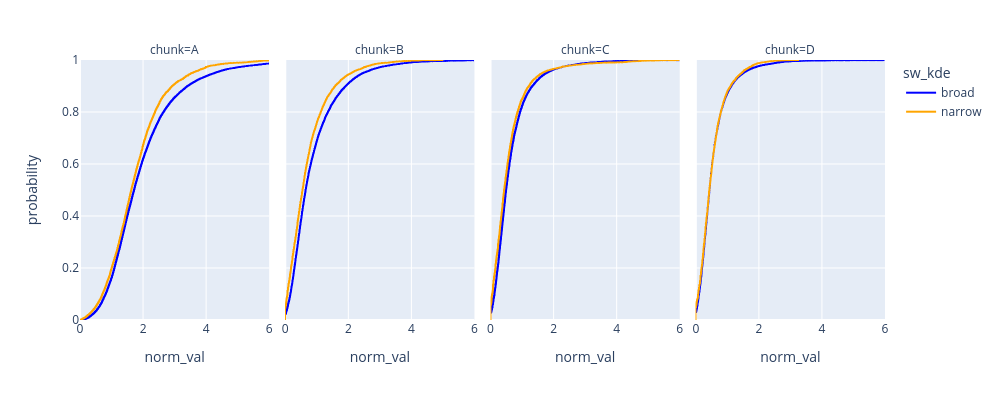

In [35]:
toplot = toregress.dropna(subset='sw_kde')
fig = px.ecdf(toplot.query("sw_kde != 'unclass'"),
              x="norm_val", color='sw_kde', facet_col='chunk',
              color_discrete_map={'narrow': 'orange',
                                  'broad': 'blue'},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

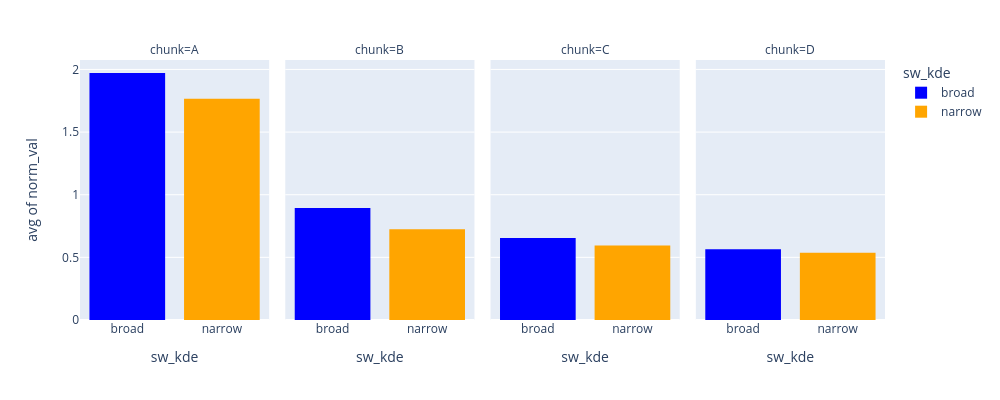

In [36]:
fig = px.histogram(toplot.query("sw_kde != 'unclass'"),
                   x='sw_kde', y='norm_val', color='sw_kde', facet_col='chunk', histfunc='avg',
             color_discrete_map={'narrow': 'orange',
                                  'broad': 'blue'},)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [37]:
for chunk in  toplot.chunk.unique():
    x = toplot.query(f"chunk == '{chunk}' and  sw_kde == 'narrow'").norm_val
    y = toplot.query(f"chunk == '{chunk}' and  sw_kde == 'broad'").norm_val
    stout = sst.ranksums(x, y)
    print(f'{chunk}, {stout}')

# print(toplot.groupby(['chunk','sw_kde']).agg(mean=('norm_val', 'mean')))

A, RanksumsResult(statistic=-9.726513742170926, pvalue=2.324223209971432e-22)
B, RanksumsResult(statistic=-16.289321781806198, pvalue=1.1752529896657546e-59)
C, RanksumsResult(statistic=-12.22519329096912, pvalue=2.2803863838263137e-34)
D, RanksumsResult(statistic=-2.0581767551488928, pvalue=0.03957316911623519)


In [38]:
mod = ols("norm_val ~ C(sw_kde)*C(chunk)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     5209.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:00:48   Log-Likelihood:            -1.3947e+05
No. Observations:              117516   AIC:                         2.790e+05
Df Residuals:                  117504   BIC:                         2.791e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# phototag

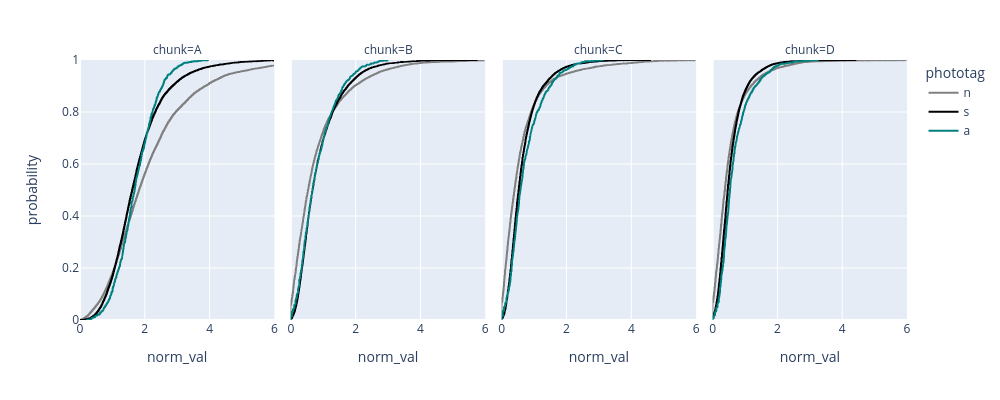

In [39]:
toplot = toregress.dropna(subset='phototag').query("phototag in ['a', 's', 'n']").copy()
toplot['phototag'] = toplot.phototag.cat.remove_unused_categories()
fig = px.ecdf(toplot, x="norm_val", color='phototag', facet_col='chunk',
              color_discrete_map={"a": "teal",
                                  "s": "black",
                                  "n": "gray"},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [40]:
mod = ols("norm_val ~ C(phototag)*C(chunk)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     4552.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:00:56   Log-Likelihood:            -1.2201e+05
No. Observations:              102584   AIC:                         2.440e+05
Df Residuals:                  102572   BIC:                         2.442e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## both groups
3 photocategories, 2 spikewidth categories

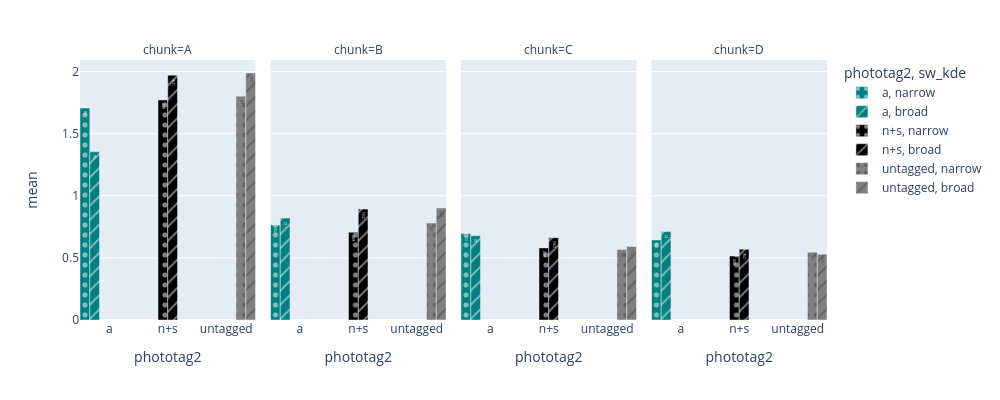

In [41]:
toplot = toregress.query("sw_kde in ['narrow', 'broad']"
                         ).groupby(['phototag2', 'sw_kde', 'chunk']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()

fig = px.bar(toplot,
             x='phototag2', y='mean', pattern_shape='sw_kde', color='phototag2', facet_col='chunk',
             barmode='group', text='count',
             pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
             color_discrete_map={'a': 'teal', 'n+s': 'black', 'untagged': 'gray'},
             category_orders={'sw_kde': ['narrow', 'broad'],
                              'phototag2': ['a', 'n+s', 'untagged']})

# fig.update_traces(width=0.2)
fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

## double classification
This should not change much, the idea is that we merge putative narrow wave with photoactivated and we call
it putative inhibitory interneurons. on the oter hand we take broad spikes that are not photo activated and
we classify them as putative exitatory neurons.
In other words the narrow wave cluster is gaining some exited neurons, and the wide cluster is loosing some.

In [42]:
putative = np.empty(toregress.shape[0], dtype=object)
inhibitory = np.logical_or(toregress.phototag == 'a', toregress.sw_kde == 'narrow')

pyramidal = np.logical_and(np.logical_or(toregress.phototag != 'a',
                                         toregress.phototag.isnull()),
                           toregress.sw_kde == 'broad')

putative[inhibitory] = 'inhibitory'
putative[pyramidal] = 'pyramidal'

toregress['putative'] = pd.Series(putative, dtype='category')

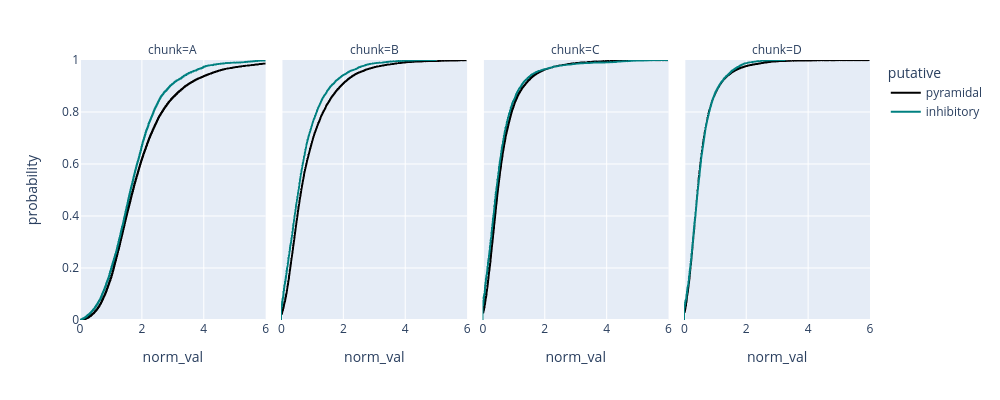

In [43]:
toplot = toregress.query("putative in ['inhibitory', 'pyramidal']")
fig = px.ecdf(toplot, x="norm_val", color='putative', facet_col='chunk',
              color_discrete_map={"inhibitory": "teal",
                                  "pyramidal": "black"},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

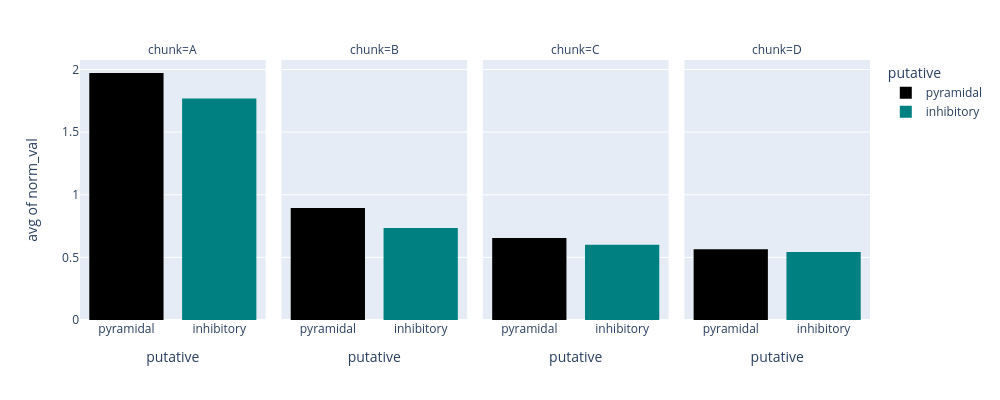

In [44]:
fig = px.histogram(toplot, x="putative", y='norm_val', color='putative', facet_col='chunk', histfunc='avg',
              color_discrete_map={"inhibitory": "teal",
                                  "pyramidal": "black"},)
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [45]:
mod = ols("norm_val ~ C(chunk) * C(putative)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     7516.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:01:05   Log-Likelihood:            -1.3162e+05
No. Observations:              110488   AIC:                         2.633e+05
Df Residuals:                  110480   BIC:                         2.633e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

# what if we take means per neuron??
same story

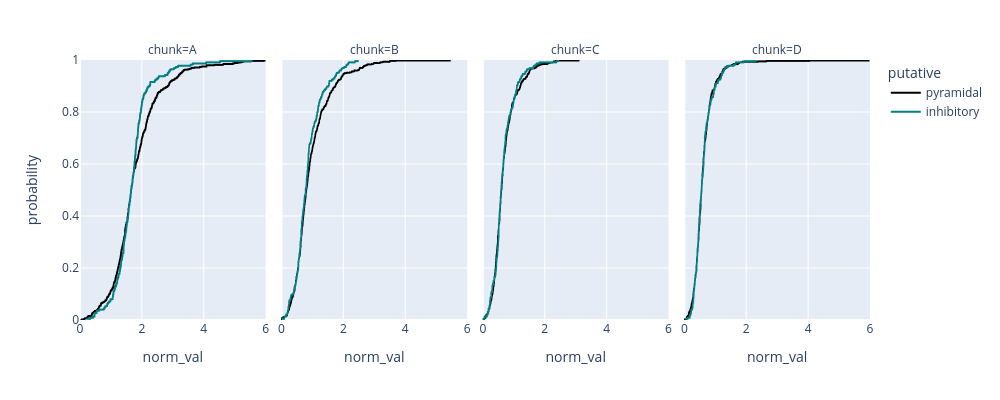

In [46]:
toplot = toregress.groupby(['id', 'putative', 'chunk'],
                           observed=True).agg(norm_val=('norm_val', 'mean')).reset_index()
fig = px.ecdf(toplot, x="norm_val", color='putative', facet_col='chunk',
              color_discrete_map={"inhibitory": "teal",
                                  "pyramidal": "black"},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

# back to full duration
since there is nothing particularly interesting for individual time chunks, rater focus on the full length

In [47]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
metrics = ['integral_nosig', 'integral', 'last_bin']
DF_ns = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} "
                                    f"and cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' "
                                    f"and analysis == 'SC' "
                                    )


DF_ns['value_nosig'] = pd.to_numeric(DF.value, downcast='float')
DF_ns['metric'] = 'integral' #gotta
DF_ns.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis','value'], inplace=True)
DF_ns.reset_index(drop=True, inplace=True)
normalizer =DF_ns.groupby(by=['metric'], observed=True).agg(grand_mean=('value_nosig',np.mean)).reset_index()

DF_ns = pd.merge(DF_ns, normalizer, on=['metric'], validate="m:1")
DF_ns['norm_val_nosig'] = DF_ns['value_nosig']/DF_ns['grand_mean']
DF_ns.drop(columns=['grand_mean', 'site', 'region', 'stim_count'], inplace=True)
DF_ns.head()

,id,context_pair,probe,metric,value_nosig,norm_val_nosig
0,TNC012a-06-2,00_01,1,integral,225.812958,2.067870
1,TNC012a-11-3,00_01,1,integral,127.818657,1.170493
2,TNC012a-11-4,00_01,1,integral,68.169952,0.624263
3,TNC012a-19-3,00_01,1,integral,85.212440,0.780329
4,TNC012a-20-1,00_01,1,integral,201.391022,1.844228


In [48]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
metrics = ['integral', 'last_bin', 'integral_nosig']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} "
                                    f"and cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' "
                                    f"and analysis == 'SC' "
                                    )

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis',], inplace=True)
DF['metric'] = DF.metric.cat.remove_unused_categories()
DF.reset_index(drop=True, inplace=True)

signif_filter = DF.query("metric == 'integral' and value > 0").loc[:,['id', 'context_pair', 'probe']].copy()
signif_filter['significant'] = True

DF = pd.merge(DF, signif_filter, on=['id','context_pair','probe'], how='left', validate='m:1')
DF.loc[DF.significant.isnull(),'significant'] = False
DF['significant'] = DF.significant.astype(bool)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'stim_count']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

DF = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
DF['norm_val'] = DF['value']/DF['grand_mean']
DF.drop(columns=['grand_mean'], inplace=True)

# add celltype labels
toregress = pd.merge(DF,
                     toclust.loc[:,['id', 'sw', 'phototag2', 'phototag3', 'sw_kde', 'putative', 'triple']],
                     on='id', validate="m:1").reset_index(drop=True)

print(toregress.shape)
toregress.head()

(1069650, 16)


,id,context_pair,probe,value,metric,site,region,stim_count,significant,norm_val,sw,phototag2,phototag3,sw_kde,putative,triple
0,ARM032a-12-1,00_01,1,0.0,integral,ARM032a,A1,4,False,0.0,0.62074,untagged,False,broad,pyramidal,broad
1,ARM032a-12-1,00_02,1,0.0,integral,ARM032a,A1,4,False,0.0,0.62074,untagged,False,broad,pyramidal,broad
2,ARM032a-12-1,00_03,1,0.0,integral,ARM032a,A1,4,False,0.0,0.62074,untagged,False,broad,pyramidal,broad
3,ARM032a-12-1,00_04,1,0.0,integral,ARM032a,A1,4,False,0.0,0.62074,untagged,False,broad,pyramidal,broad
4,ARM032a-12-1,01_02,1,0.0,integral,ARM032a,A1,4,False,0.0,0.62074,untagged,False,broad,pyramidal,broad


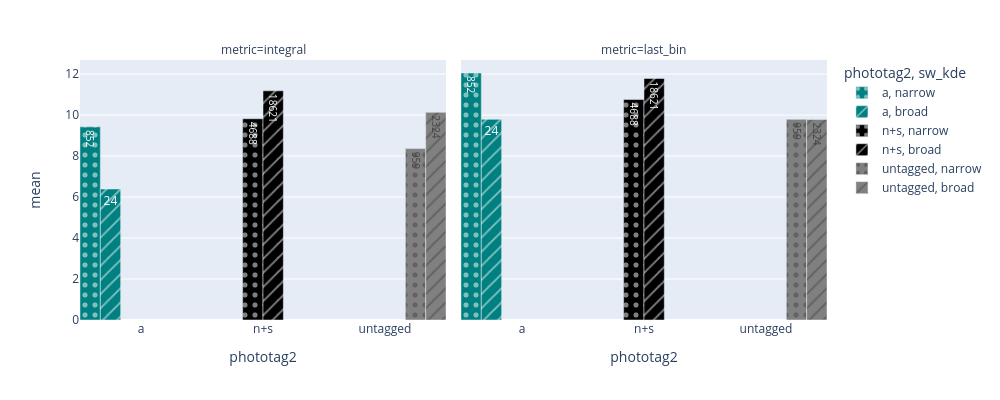

In [49]:
toplot = toregress.query("sw_kde in ['narrow', 'broad'] "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).groupby(['phototag2', 'sw_kde', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()
toplot.dropna(subset='mean', inplace=True)
fig = px.bar(toplot,
             x='phototag2', y='mean', pattern_shape='sw_kde', color='phototag2',
             barmode='group', text='count', facet_col='metric',
             pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
             color_discrete_map={'a': 'teal', 'n+s': 'black', 'untagged': 'gray'},
             category_orders={'sw_kde': ['narrow', 'broad'],
                              'phototag2': ['a', 'n+s', 'untagged']})

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

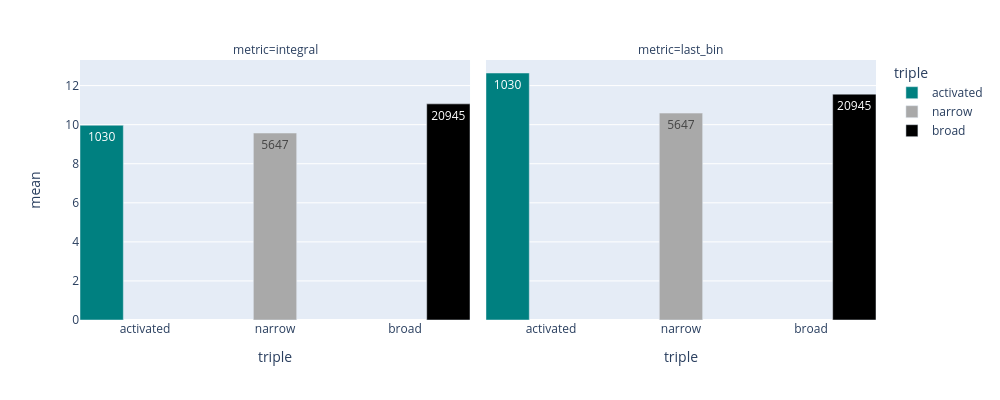

In [169]:
toplot = toregress.query("triple in ['activated', 'narrow', 'broad'] "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()
toplot = toplot.groupby(['triple', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()


fig = px.bar(toplot,
             x='triple', y='mean', color='triple',
             barmode='group', text='count', facet_col='metric',
             # pattern_shape='triple',
             # pattern_shape_map={'narrow': '.', 'activated': '.', 'broad': '/'},
             color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad'],
                              })

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

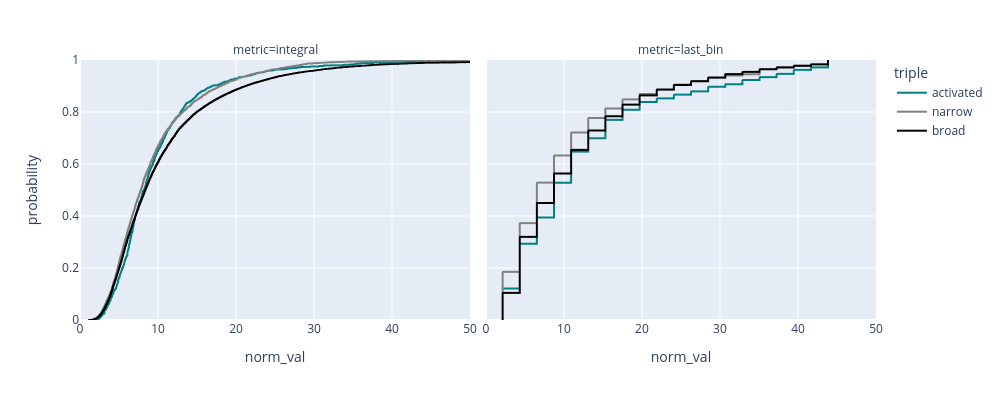

In [163]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='norm_val', color='triple', facet_col='metric',
              color_discrete_map={'activated': 'teal', 'narrow': 'gray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               })

fig.update_layout(bargap=0.0, bargroupgap=0.0,
                  xaxis_range=[0, 50],
                  yaxis_range=[0, 1])

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

### shuffle test of difference on nth quantile

In [147]:
mod = quantreg("norm_val ~ C(triple)", toplot.query("metric == 'integral'"))
res = mod.fit(q=0.75)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:               norm_val   Pseudo R-squared:             0.002785
Model:                       QuantReg   Bandwidth:                      0.7703
Method:                 Least Squares   Sparsity:                        29.54
Date:                Thu, 01 Sep 2022   No. Observations:                27622
Time:                        17:07:47   Df Residuals:                    27619
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.6644      0.399     29.252      0.000      10.883      12.446
C(triple)[T.broad]      1.5317      0.408      3.750      0.000       0.731       2.332
C(triple)[T.narrow]     0.0326      0.434      0.075      0.940      -0.817       0.882


In [53]:
import itertools as itt
df = list()
for met in  toplot.metric.unique():
    for c0, c1 in itt.combinations(toplot.triple.unique(),r=2):
        x = toplot.query(f"metric == '{met}' and  triple == '{c0}'").norm_val
        y = toplot.query(f"metric == '{met}' and  triple == '{c1}'").norm_val
        stout = sst.ranksums(x, y)
        df.append(dict(metric=met, class0=c0, class1=c1,
                       mean0=np.median(x), mean1=np.median(y),
                       quant0=np.quantile(x, 0.75), quant1=np.quantile(y, 0.75),
                       pvalue=stout.pvalue))
        # print(f'{met} {c0} vs {c1}, {stout}')

df = pd.DataFrame(df)
df['significant'] = df['pvalue'] < 0.05/df.shape[0]
df

,metric,class0,class1,mean0,mean1,quant0,quant1,pvalue,significant
0,integral,narrow,broad,7.796036,8.368795,11.697037,13.196106,4.143862e-17,True
1,integral,narrow,activated,7.796036,8.212757,11.697037,11.663828,4.348188e-03,True
2,integral,broad,activated,8.368795,8.212757,13.196106,11.663828,2.302535e-01,False
3,last_bin,narrow,broad,6.587722,8.783629,13.175445,15.371352,2.294488e-30,True
4,last_bin,narrow,activated,6.587722,8.783629,13.175445,15.371352,2.270630e-12,True
5,last_bin,broad,activated,8.783629,8.783629,15.371352,15.371352,2.474120e-02,False


## non singificant
same as above but considering integral regardless of significance.
what thise somehow bring into the plot the proportion of significance instances per group,
but obscures the group differences in  the actual significant contextual effects

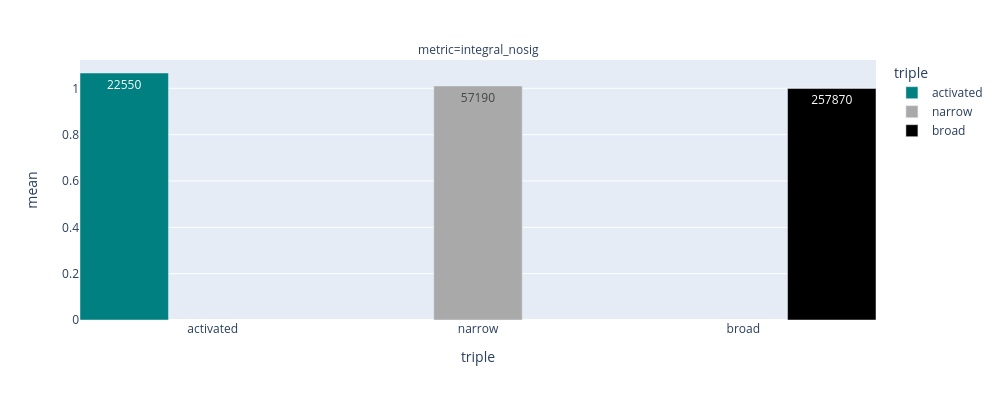

In [170]:
toplot = toregress.query("triple in ['activated', 'narrow', 'broad'] "
                         "and metric in ['integral_nosig']"
                         # "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()
toplot = toplot.groupby(['triple', 'metric']).agg(
    mean=('norm_val', 'mean'), count=('norm_val', 'count')).reset_index()


fig = px.bar(toplot,
             x='triple', y='mean', color='triple',
             barmode='group', text='count', facet_col='metric',
             # pattern_shape='triple',,
             # pattern_shape_map={'narrow': '.', 'activated': '.', 'broad': '/'},
             color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad'],
                              })

fig.update_layout(bargap=0.0, bargroupgap=0.0)

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

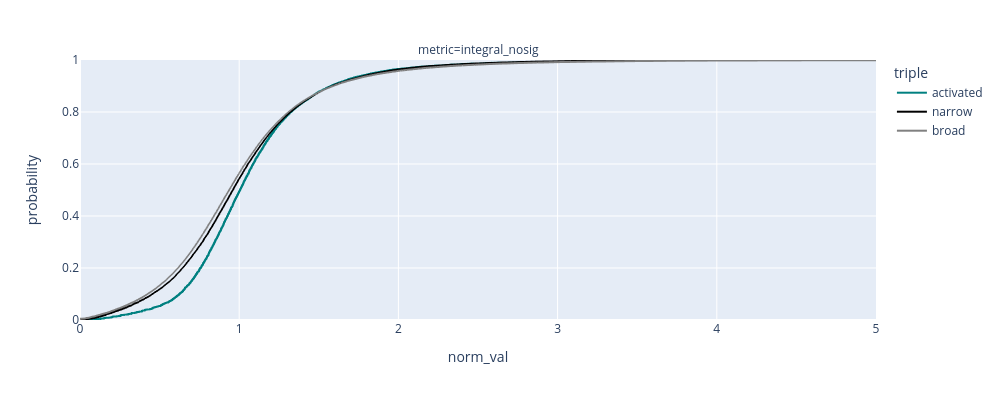

In [54]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral_nosig']"
                         # "and significant"
                         ).copy()
toplot['triple'] = toplot.triple.cat.remove_unused_categories()
toplot['metric'] = toplot.metric.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='norm_val', color='triple', facet_col='metric',
              color_discrete_map={'activated': 'teal', 'narrow': 'black', 'broad': 'gray'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               })

fig.update_layout(bargap=0.0, bargroupgap=0.0,
                  xaxis_range=[0, 5],
                  yaxis_range=[0, 1])

# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [55]:
import itertools as itt
df = list()
for met in  toplot.metric.unique():
    for c0, c1 in itt.combinations(toplot.triple.unique(),r=2):
        x = toplot.query(f"metric == '{met}' and  triple == '{c0}'").value
        y = toplot.query(f"metric == '{met}' and  triple == '{c1}'").value
        stout = sst.ranksums(x, y)
        df.append(dict(metric=met, class0=c0, class1=c1,
                       mean0=np.mean(x), mean1=np.mean(y), pvalue=stout.pvalue))
        # print(f'{met} {c0} vs {c1}, {stout}')

df = pd.DataFrame(df)
df['significant'] = df['pvalue'] < 0.05/df.shape[0]
df

,metric,class0,class1,mean0,mean1,pvalue,significant
0,integral_nosig,broad,narrow,259.218445,261.922028,2.428281e-29,True
1,integral_nosig,broad,activated,259.218445,276.463867,1.932277e-183,True
2,integral_nosig,narrow,activated,261.922028,276.463867,9.226648e-77,True


# check proportion
what number of significant instances per category? is there a greater likelyhood of showing contextual
effects for inhibitory or pyramidal neurons?

  phototag2  sw_kde  sig_prcnt   count
0       n+s   broad   7.729763  240900
1       n+s  narrow   9.797283   47850
2         a   broad   1.454545    1650
3         a  narrow   4.997067   17050
4  untagged   broad   0.303030    1650
5  untagged  narrow   0.242424    3300


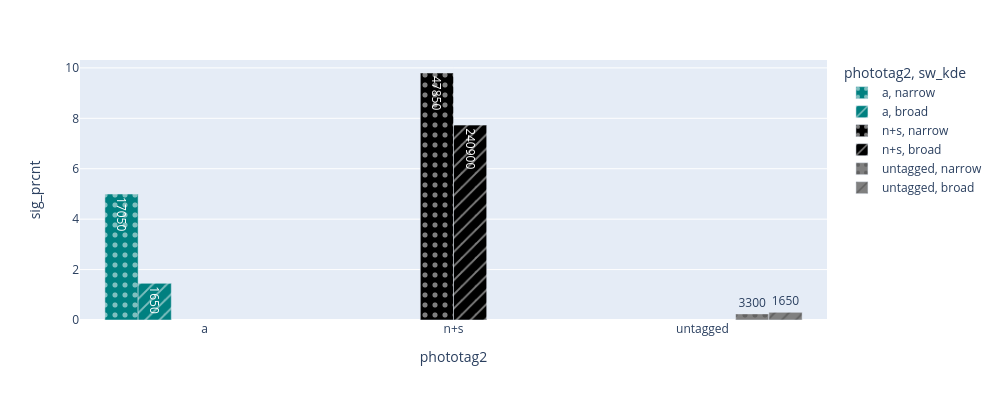

In [135]:
sig_prop = toregress.query(
    "sw_kde in ['narrow', 'broad'] "
    "and metric == 'integral' "
    "and stim_count in [9, 10]"
).groupby(
    ['phototag2', 'sw_kde'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()

print(sig_prop)
fig = px.bar(sig_prop,
             x='phototag2', y='sig_prcnt', pattern_shape='sw_kde', color='phototag2',
             text='count',
             barmode='group',
             pattern_shape_map={'narrow': ".", "unclass": "", "broad": "/"},
             color_discrete_map={'a': 'teal', 'n+s': 'black', 'untagged': 'gray'},
             category_orders={'sw_kde': ['narrow', 'broad'],
                              'phototag2': ['a', 'n+s', 'untagged']})

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

      triple  sig_prcnt   count
0      broad   7.679241  242550
1     narrow   9.180841   51150
2  activated   4.567627   22550


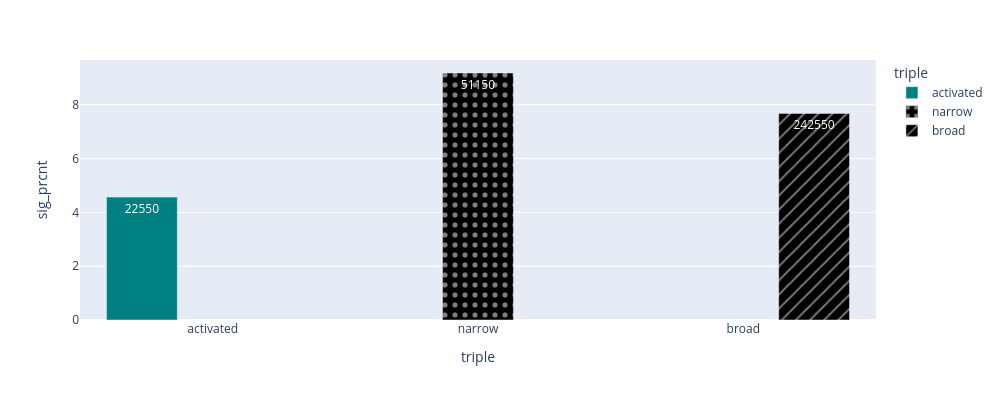

In [134]:
sig_prop = toregress.query(
    "triple in ['activated', 'narrow', 'broad'] "
    "and metric == 'integral' "
    "and stim_count in [9, 10]"
).groupby(
    ['triple'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()

print(sig_prop)
fig = px.bar(sig_prop,
             x='triple', y='sig_prcnt', pattern_shape='triple', color='triple',
             barmode='group', text='count',
             pattern_shape_map={'narrow': '.', 'activated': '', 'broad': '/'},
             color_discrete_map={'activated': 'teal', 'narrow': 'black', 'broad': 'black'},
             category_orders={'triple': ['activated', 'narrow', 'broad']}
             )

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

# Firing rate
since firing rate has a small effect on contextthere is a slim chance that firing rate will ha

In [93]:
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220901_raw_fr_by_instance' # zscored firing rate
fr_DF = jl.load(fr_DF_file)

# simply takes the cell mean firing rate across all contexts, probes, and pupil sizes
fr_DF = fr_DF.query("chunk == 'full' and pupil == 'full' and part == 'probe' and metric == 'firing_rate'"
                  ).groupby(['id'], observed=True).agg(FR=('value', 'mean')).reset_index()

print(fr_DF.shape)
print(fr_DF.head())

(1669, 1)
                    FR
id                    
AMT020a-02-1  1.771375
AMT020a-04-1  0.437125
AMT020a-07-1  0.008250
AMT020a-08-1  0.359875
AMT020a-13-1  0.196000


In [95]:
fr_cls_DF = pd.merge(fr_DF, toclust, on=['id'], validate="1:1")

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


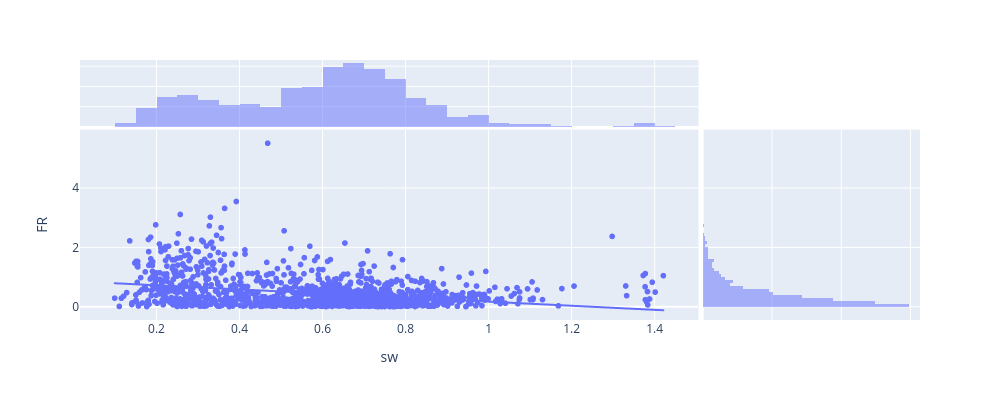

In [103]:
fig = px.scatter(fr_cls_DF, y='FR', x='sw', trendline='ols', marginal_x='histogram', marginal_y='histogram')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


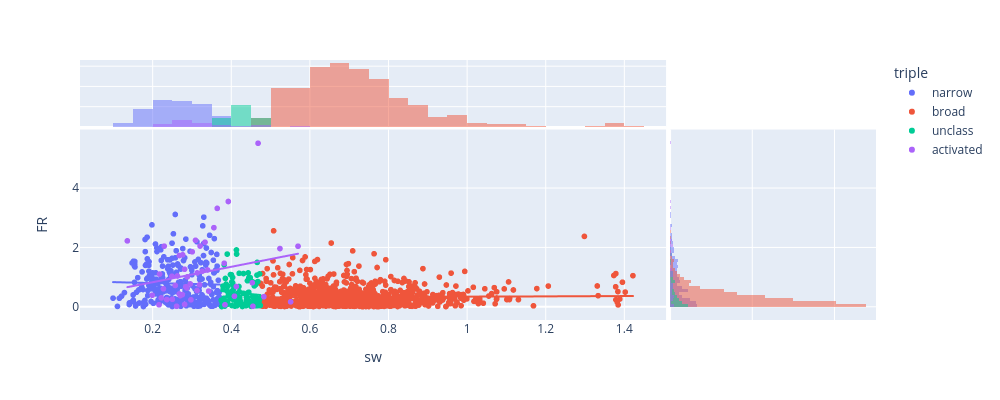

In [156]:
fig = px.scatter(fr_cls_DF, y='FR', x='sw',
                 color='triple',
                 trendline='ols', marginal_x='histogram', marginal_y='histogram')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

LinregressResult(slope=-0.14227117682925228, intercept=0.6592648478083768, rvalue=-0.3133759752228265, pvalue=1.4354705525095376e-33, stderr=0.011477353287893191, intercept_stderr=0.007833916410338402)


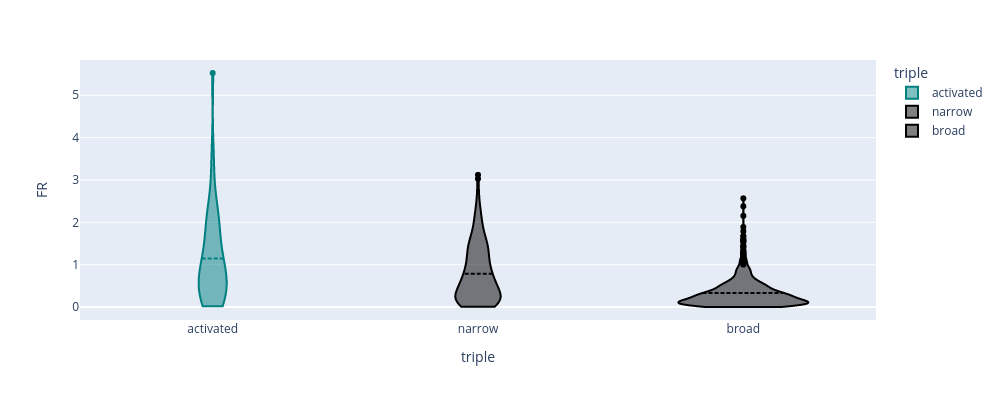

In [120]:
fig = px.violin(fr_cls_DF.query("triple != 'unclass'"),
                y='FR', x='triple', color='triple',
                color_discrete_map={'activated': 'teal', 'narrow': 'black', 'broad': 'black'},
                category_orders={'triple': ['activated', 'narrow', 'broad']},
                )
fig.update_traces(meanline_visible=True,
                  # marker_size=2,
                  # points='outliers',
                  # jitter=0.1,
                  # scalemode='width',
                  spanmode='hard')
img_bytes = fig.to_image(format="png", width=1000, height=400)
print(sst.linregress(x=fr_cls_DF.FR,y=fr_cls_DF.sw))
Image(img_bytes)

In [121]:
mod = ols("FR ~ C(triple)", data=fr_cls_DF.query("triple != 'unclass'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     FR   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     160.1
Date:                Thu, 01 Sep 2022   Prob (F-statistic):           6.27e-63
Time:                        16:10:43   Log-Likelihood:                -849.29
No. Observations:                1316   AIC:                             1705.
Df Residuals:                    1313   BIC:                             1720.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.1474 

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning:

divide by zero encountered in double_scalars



## FR vs Percent Significant
this is not in

In [137]:
sig_prcnt_DF = DF.query(
    "metric == 'integral'"
).groupby(
    ['stim_count', 'id'], observed=True
).agg(
    sig_prcnt=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()
print(sig_prcnt_DF.shape)
print(sig_prcnt_DF.head())

(1724, 4)
  stim_count            id  sig_prcnt  count
0         10  TNC012a-06-2  32.545455    550
1         10  TNC012a-11-3  29.636364    550
2         10  TNC012a-11-4  35.272727    550
3         10  TNC012a-19-3  47.090909    550
4         10  TNC012a-20-1  32.727273    550


In [138]:
fr_sig_DF = pd.merge(fr_DF, sig_prcnt_DF, on=['id'], validate="1:1")

LinregressResult(slope=7.177203518869935, intercept=8.284632396071107, rvalue=0.23303586133938273, pvalue=3.4658125412994174e-19, stderr=0.7903703969032251, intercept_stderr=0.5267228918892557)


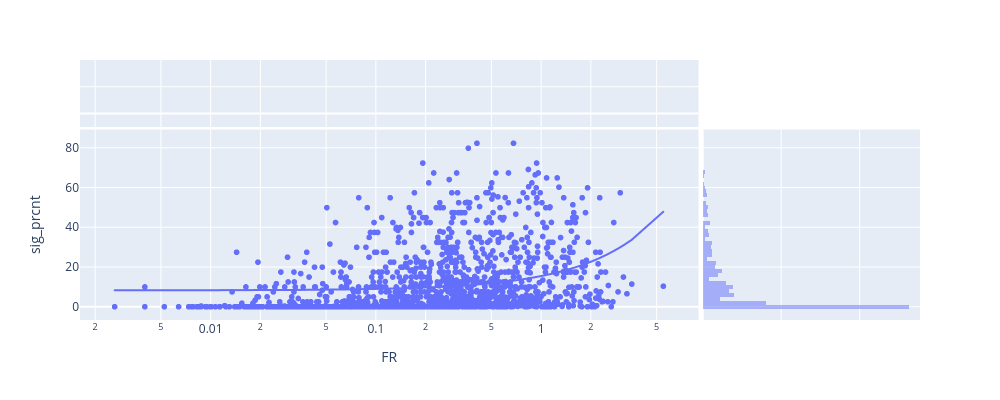

In [153]:
fig = px.scatter(fr_sig_DF, x='FR', y='sig_prcnt', trendline='ols',
                 log_x=True,
                 marginal_x='histogram', marginal_y='histogram')

print(sst.linregress(x=fr_sig_DF.FR,y=fr_sig_DF.sig_prcnt))
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [171]:
# define a set of bins for the long firing rate
fr_DF['logFR'] = np.log10(fr_DF['FR'])
q = 9
fr_DF['quant'] = pd.qcut(fr_DF['logFR'],q, labels=list(range(q)))

In [172]:
toplot = pd.merge(toregress.query("metric =='integral' and significant and triple != 'unclass'"),
                  fr_DF.reset_index(), on='id', validate='m:1')
toplot.head()

,id,context_pair,probe,value,metric,site,region,stim_count,significant,norm_val,sw,phototag2,phototag3,sw_kde,putative,triple,FR,logFR,quant
0,ARM032a-13-2,00_02,1,292.995636,integral,ARM032a,A1,4,True,13.565103,0.316247,untagged,False,narrow,inhibitory,narrow,1.604125,0.205238,8
1,ARM032a-13-2,00_02,2,88.945099,integral,ARM032a,A1,4,True,4.117977,0.316247,untagged,False,narrow,inhibitory,narrow,1.604125,0.205238,8
2,ARM032a-13-2,00_03,2,104.641296,integral,ARM032a,A1,4,True,4.844679,0.316247,untagged,False,narrow,inhibitory,narrow,1.604125,0.205238,8
3,ARM032a-13-2,00_02,3,238.058945,integral,ARM032a,A1,4,True,11.021646,0.316247,untagged,False,narrow,inhibitory,narrow,1.604125,0.205238,8
4,ARM032a-13-2,00_04,3,222.362747,integral,ARM032a,A1,4,True,10.294943,0.316247,untagged,False,narrow,inhibitory,narrow,1.604125,0.205238,8


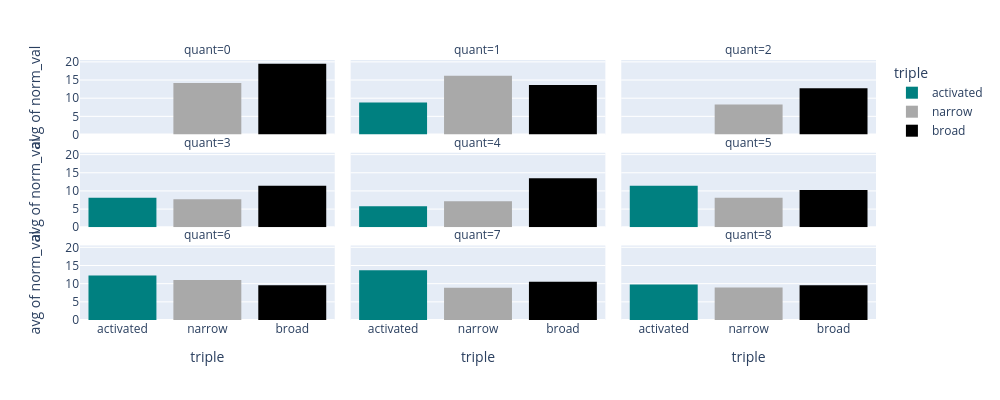

In [176]:
fig = px.histogram(toplot, x='triple', y='norm_val', color='triple', facet_col='quant', facet_col_wrap=3, histfunc='avg',
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'broad'],
                                    'quant': list(range(q))},
                   )


img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

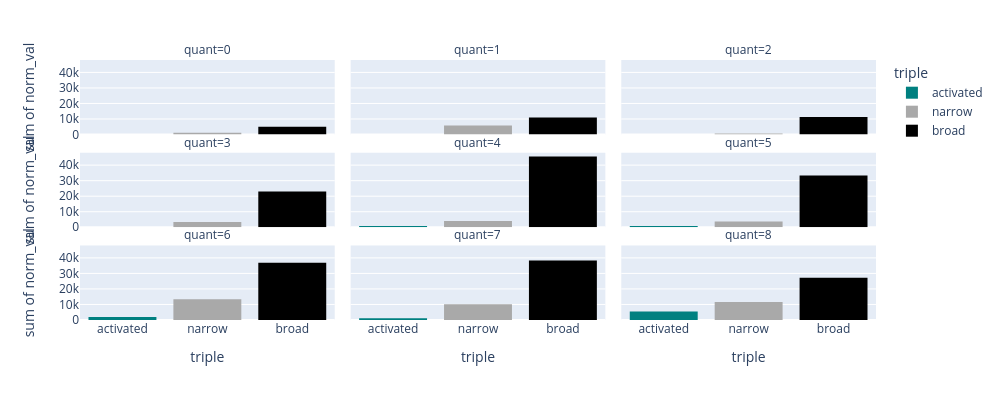

In [181]:
fig = px.histogram(toplot, x='triple', y='norm_val', color='triple', facet_col='quant', facet_col_wrap=3,
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'broad'],
                                    'quant': list(range(q))},
                   )


img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

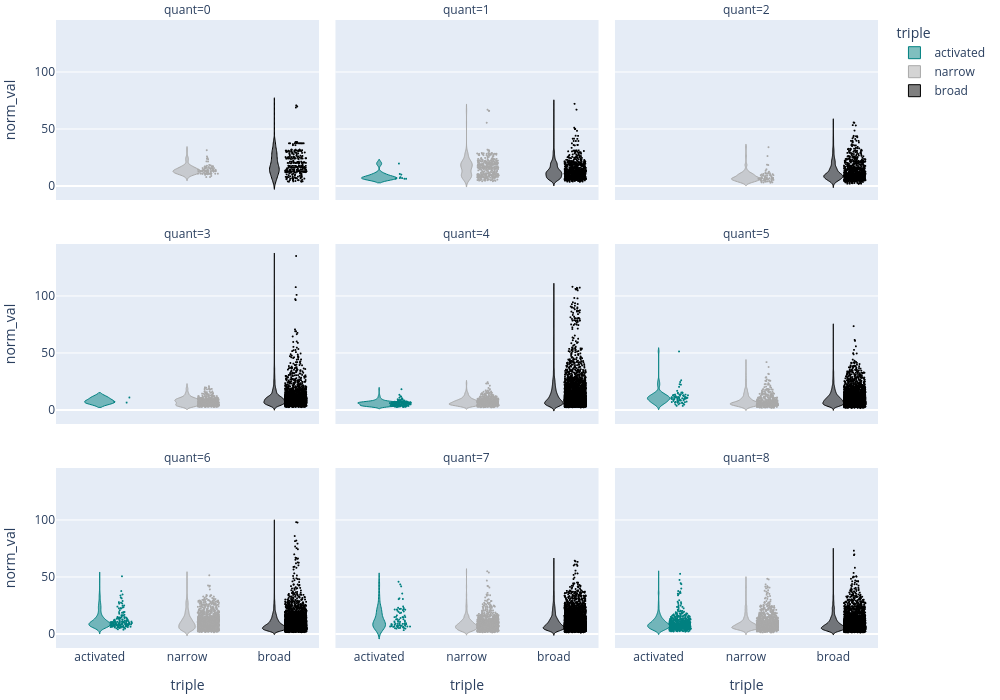

In [198]:
fig = px.violin(toplot, x='triple', y='norm_val', color='triple', facet_col='quant', facet_col_wrap=3,
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'broad'],
                                    'quant': list(range(q))},
                   )
fig.update_traces(marker_size=2,
                  points='all',
                  pointpos=1,
                  jitter=0.5,
                  line_width=1,
                  scalemode='width')

fig.update_layout(margin=dict(t=20, b=10, l=10, r=10),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=700)
Image(img_bytes)

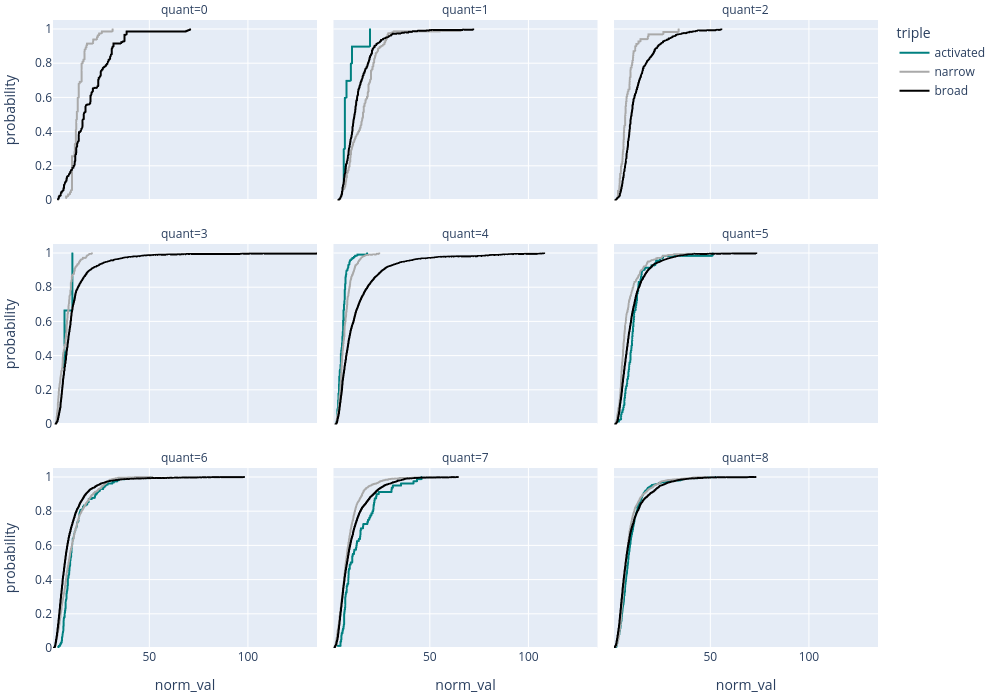

In [200]:
fig = px.ecdf(toplot, x='norm_val', color='triple', facet_col='quant', facet_col_wrap=3,
                   color_discrete_map={'activated': 'teal', 'narrow': 'darkgray', 'broad': 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'broad'],
                                    'quant': list(range(q))},
                   )
fig.update_layout(margin=dict(t=20, b=10, l=10, r=10),
                  )

img_bytes = fig.to_image(format="png", width=1000, height=700)
Image(img_bytes)

In [251]:
df = list()
for qq in toplot.quant.unique():
    mod = quantreg("norm_val ~ C(triple)", toplot.query(f"quant == {qq}"))
    res = mod.fit(q=0.75)

    # print(res.summary())
    ww = res.params
    ww.name = f'params'

    pp = res.pvalues
    pp.name = f'pvalues'

    out = pd.concat([ww, pp], axis=1)
    out.drop(index=['C(triple)[T.unclass]'], inplace=True)
    # out.rename(index={'Intercept':'activated','C(triple)[T.broad]': 'broad', 'C(triple)[T.narrow]':'narrow'},
    #            inplace=True)
    out['quant'] = qq
    df.append(out)
df = pd.concat(df)

df['significant'] = df['pvalues'] < (0.05 / df.shape[0])
df.reset_index(inplace=True)
df = df.sort_values(by=['quant', 'index'], ascending=[True, True], ignore_index=True)
df.set_index(['quant', 'index'], inplace=True)
print(df)

                              params        pvalues  significant
quant index                                                     
0     C(triple)[T.broad]   11.694905   1.567758e-54         True
      C(triple)[T.narrow]   2.001545   1.823864e-02        False
      Intercept            13.696450   8.285198e-95         True
1     C(triple)[T.broad]    6.937752   6.493568e-02        False
      C(triple)[T.narrow]  10.184246   7.190135e-03        False
      Intercept             9.983059   7.623518e-03        False
2     C(triple)[T.broad]    7.173026   1.249507e-33         True
      C(triple)[T.narrow]   1.170108   2.426441e-01        False
      Intercept             8.343134   2.589004e-52         True
3     C(triple)[T.broad]    1.446654   7.690380e-01        False
      C(triple)[T.narrow]  -1.321881   7.889188e-01        False
      Intercept            10.963886   2.603868e-02        False
4     C(triple)[T.broad]    8.936890   9.494376e-19         True
      C(triple)[T.narrow]

In [230]:
ww = res.params
ww.name = f'params'

pp = res.pvalues
pp.name = f'pvalues'

out = pd.concat([ww, pp], axis=1)
out.drop(index=['C(triple)[T.unclass]'], inplace=True)
out.rename(index={'Intercept':'activated','C(triple)[T.broad]': 'broad', 'C(triple)[T.narrow]':'narrow'},
           inplace=True)
out['quant'] = qq
out

,params,pvalues,quant
activated,18.707384,2.385763e-46,1
broad,-5.653811,1.600245e-05,1
narrow,-7.662044,1.127440e-08,1


# list of CPN sites to phototag
nothing special, just to keep track of it

In [60]:
all_proc_sites = set(get_phototags().siteid)

all_opto_sites={'ARM004e', 'TNC006a', 'TNC008a', 'TNC009a', 'TNC010a', 'TNC011a',
       'TNC012a', 'TNC013a', 'TNC014a', 'TNC015a', 'TNC016a', 'TNC017a',
       'TNC018a', 'TNC019a', 'TNC020a', 'TNC021a', 'TNC022a', 'TNC023a',
       'TNC024a', 'TNC029a', 'TNC043a', 'TNC044a', 'TNC045a', 'TNC047a',
       'TNC048a', 'TNC049a', 'TNC050a', 'TNC051a', 'TNC062a', 'CLT027c',
       'CLT028c', 'CLT031c', 'CLT032c', 'CLT033c', 'CLT034c', 'CLT035c',
       'CLT036c', 'CLT037c', 'CLT038a', 'CLT039c', 'CLT040c', 'CLT041c',
       'CLT042a', 'CLT043b', 'CLT044d', 'CLT045d', 'CLT048c', 'CLT049c'}

all_ctx_sites= set(DF.site.unique())


all_unproc = set(all_opto_sites).difference(set(all_proc_sites))
ctx_unproc = all_unproc.intersection(set(all_ctx_sites))
ctx_unproc

set()